# Echo state network on Lorenz and Sin dataset

### Author: Daniel Mai 

## Project specification

Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

- Tasks for the remaining project:
    - rework on the split train test data - need to apply the k correctly: When the k steps applied, the training set will be applied too. For instance, if k = 2, then the input-output pair should be using 2 steps as well. (DONE)
    - rework on the split train test data - need to apply the n - how many inputs (input dimension) we want to apply to find the output.
    - Apply the regularization parameter on the training of the W_out as well (currently the project is working without regularization) (DONE)
    - Cross-validation - to choose best hyper-parameters for the following hyperparameters: 
        - a (spectral radius) 
        - n_reservoirs - number of reservoir neurons
        - the $\lambda$ - regularization hyper-param
    - Plot in different dimensions (if possible)
    - Write reports

In [1]:
import matplotlib.pyplot as plt
# make sure plots are correctly displayed in the notebook
%matplotlib inline
import numpy as np

### Reading from files 

In [2]:
def read_file(file_name='lorenz.txt'):
    data = np.genfromtxt(file_name, delimiter='\n', dtype=float)
    return data

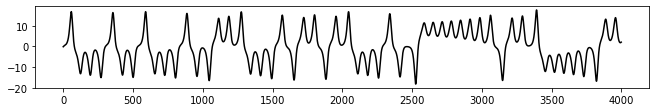

In [3]:
data = read_file()
trainlen = 2000
future = 2000
plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),data[:trainlen+future],'k',label="target system")

Text(0.5, 1.0, 'A sample of data of lorentz')

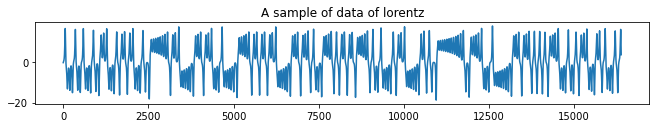

In [4]:
plt.figure(figsize=(11,1.5))
plt.plot(data[:])
plt.title('A sample of data of lorentz')

### Process the dataset based on the k-step ahead forecasting

- Note: The value of n in the description here I defined to be 1

- Pair data will be split based on k
    - The value of time step t will be paired with the value of time step t+k
    - io_pair $\in R^{(N - k) x 2}$ where N is the number of datas.
    - train_pair $\in R^{(N - k - k) x 2}$ which is used to train the model.
    - test_pair $\in R^{k x 2}$ which is used to test the model.

In [258]:
def train_test_split(data, k=20):
    '''
        Args:
            data : original data read from files (N,)
            k    : steps for ahead forecasting
        Returns: 
            io_pair ((N-k,2)) : input-output pair of whole data
            train_pair ((N-k-k,2)) : input-output training pair  
            test_pair ((k,2)) : input-output test pair
        
    '''
    io_pair = np.zeros((len(data) - k, 2), dtype=float)
    #io_pair = np.zeros((len(data) - 1, 2))
    for i in range(len(data) - k):
        io_pair[i, 1] = data[i + k] # setting the output
        io_pair[i, 0] = data[i]

#     for i in range(len(data) - 1):
#         io_pair[i, 0] = data[i]
#         io_pair[i, 1] = data[i+1]
        
        
    split = io_pair.shape[0] - 25
    train_pair = io_pair[:split, :]
    test_pair = io_pair[split:, :]
    
    return io_pair, train_pair, test_pair

### Initliaze randomized weights

- Elements of **$W^i$** is independently drawn from a uniform distribution in [−1, 1]
- Elements of **$W^r$** directly impacts on the “dynamics” of the network and therefore requires more:
    - uniformly in [-1, 1]
    - $W^r = a\frac{W_r}{p(W^r)}$ where $p(W^r)$ is the spectral radius of $W^r$ and **a** is a scalar hyper-parameter.

In [259]:
def initialize_weights(input_dim, a, n_reservoirs):
    '''
        Args:
            input_dim   : input dimensions
            a           : scalar - hyper-parameter
            n_reservoirs: number of reservoir neurons
        Returns:
            W_in: input-to-recurrent layer weights
            W_r: recurrent layer weights
    '''
    
    W_in = (np.random.rand(n_reservoirs, input_dim) - 0.5) * 1
    W_r = np.random.rand(n_reservoirs, n_reservoirs) - 0.5
    
    # compute the spectral radius of these weights
    spectral_radius = max(abs(np.linalg.eig(W_r)[0]))
    
    # rescale W_r
    W_r = (W_r*a)/spectral_radius
    
    return W_in, W_r

### Metrics for evaluating prediction performance

* Mean-squared error (MSE)

$$
MSE = 〈||t-z||^2〉
$$

    where〈·〉indicates average over time, t and z are target and predicted values, respectively.


* Normalized root MSE (NRMSE)

$$
NRMSE = \frac{\sqrt{MSE}}{var(t)}
$$

In [260]:
def MSE(target, predicted):
    '''
    Args:
        target: target values
        predicted: predicted values
    Returns:
        loss of the model
    '''
    return np.square(np.subtract(target,predicted)).mean()

def NRMSE(target, predicted):
    return MSE(target, predicted)/np.var(t, ddof=1)

### Implement ESN network

#### Standard ESN model:

$x^t = \phi(W^r x_{t-1} + W^i u_t)$         

$z_t = W^o x_t$                             

- where $W^r$ and $W^i$ are randomly initialized, and $W^o$ is obtained as a solution to a (regularized) least-square problem

    - $W^r \in R^{N_r x N_r}$, where $N_r$ is the number of neurons in the recurrent layer (reservoir)
    - $W^i \in R^{N_r x N_i}$ is the input-to-reservoir weight matrix, $N_i$ is the input dimension
    - $W^o \in R^{N_o x N_r}$ is the read-output weight matrix, $N_o$ is the output dimension 
    - Activation function $\phi(x)$, I will use in this project is the **tanh** activation function 
    
    - **NOTE**: In this project, **N_o** and **N_i** is equal to 1 since we are dealing with ***unidimensional*** dataset



- The state $x_t$ can be seen as a vector of **temporal features**

- The sequence of states $x_t, t = 1,..., N$ is the **representation learned** by the ESN of the driving input $u_t$, $t = 1,...,N$

#### Ridge regression for the read-out weights

- Regularized least-square problem for $W_o$: 

    arg min $\frac{1}{2}||XW - t||^2 + \frac{\lambda}{2}||W||^2$ where $\lambda >= 0$ is the *regularization parameter*
    
    
- The closed form solution for the above problem is:

    $W^o = (X^TX + \lambda I)^{-1}X^Tt$ where **I** is an $N_r x N_r$ identity matrix
    
    - $W^o$ should be **transposed** before further use in the model
    
    
- Assume a supervised task (such as forecasting) and dataset $\{u_i, t_i\}^N_{i=1}$

Steps for **batch training**:
1. Initialize all model parameters $W^i$, $W^r$
2. Initialize the first state as $x_0 = 0$
3. Feed the network with the sequence of inputs $u_i$, i = 1, ...,N
4. Collect the resulting N states $x_i$ in a matrix $X \in R^{N x N_r}$
5. Store all related targets in a N-dimensional vector $t \in R^N$
6. Find $W^o$ by solving a regularized least-square problem

In [278]:
def ESN_train(train_pair, n_reservoirs=200, a=0.95, lamda=0.01):
    '''
        Args:
            train_pair ((N,2)) : training input-output pair  where N is number of training pairs
            n_reservoirs       : number of reservoir neurons
            a                  : scalar - hyper-parameter used for initialize recurrent weights 
            lamda              : hyper-parameter used in ridge regression for read-out weights
        Returns:
            W_in
            W_r
            W_out ((, N_r))       : read-output weight matrix
    '''
    n_inputs = train_pair.shape[0]
    
    # initialize all model weights/parameters
    # Note: I hardcoded the input dimension (= 1) here
    #       since the input data set is unidimensional.
    W_i, W_r = initialize_weights(1, a, n_reservoirs) 
    
    # initialize the first state
    x = np.zeros((n_reservoirs, 1))
    
    # initialize holder for collecting N states x_i in a matrix X 
    X = np.zeros((n_inputs, n_reservoirs))
    
    # Feed the network with sequence of inputs u_i
    # and collect the resulting N states x_i in a matrix X.
    for i in range(n_inputs):
        u = np.array(train_pair[i, 0]) # inputs
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, u))  
        X[i, :] = x.squeeze()
    
    # Store all targeted values for those training inputs in a N-dimensional vector
    t = np.array(train_pair[:, 1])
    t = np.expand_dims(t, axis=0)
    
    # calculating W_o
    X = X.T
    W_o = np.linalg.solve(np.dot(X, X.T) + np.multiply(lamda,np.identity(n_reservoirs)), np.dot(X, t.T)).T
    return x, W_i, W_r, W_o

In [279]:
data = read_file("lorenz.txt")
iopair, training_pair, testing_pair = train_test_split(data)
current_state, W_i, W_r, W_o = ESN_train(training_pair)

In [280]:
print(W_o.shape)

(1, 200)


In [281]:
def ESN_k_step_predict(test_pair, x, W_in, W_r, W_out, k=20):
    '''
        Args:
            training_pair    : training input-output pair ((N,2)) where N is number of training pairs
            x                : current state after finish training
            W_in
            W_r
            W_out ((1, N_r)) : optimized read-output weight matrix
            k                : steps for ahead forecasting (hyperparameter)
        Returns:
            loss             : 
            targeted_values  : 
            predicted_values : 
    '''
    
    # intialize holder for predicted time series
    #predicted_values = np.zeros((1,k)) 
    predicted_values = np.zeros((1,25)) 
    # get the input time value
    u = np.array(test_pair[0,0])
    
    for t in range(test_pair.shape[0]):
        x = np.tanh(np.dot(W_in,u) + np.dot(W_r,x))
        z = np.dot(W_out, x)
        predicted_values[:,t] = z
        u = z

    targeted_values = np.expand_dims(test_pair[:,1], axis=0)

    loss = MSE(targeted_values, predicted_values)
    
    return loss, targeted_values, predicted_values
    

In [282]:
loss, targets, predicts = ESN_k_step_predict(testing_pair, current_state, W_i, W_r, W_o)

In [283]:
loss

9574.102321835271

In [284]:
targets

array([[12.24194 , 13.025714, 13.781908, 14.488091, 15.119361, 15.649582,
        16.05312 , 16.306936, 16.392811, 16.299339, 16.023375, 15.570592,
        14.955072, 14.19797 , 13.325512, 12.366673, 11.350908, 10.306204,
         9.257641,  8.2265  ,  7.229871,  6.280668,  5.387925,  4.557258,
         3.791413]])

In [285]:
predicts

array([[  12.11403518,  112.85051954,  -87.00695001,  -15.93580721,
          53.93327414,   10.53951953,  -99.66967283,   16.1617632 ,
         171.80844429, -109.71426284,   -7.47155233,  148.78126864,
         -41.33907229,  -54.3661857 ,   84.25343296,   12.91353486,
         -75.12878971,    3.38040949,  336.53692478,  -82.83607779,
         -24.0810399 ,   63.37034705,   13.73115847,  -65.23533641,
          -2.24100907]])

### Plot Functions

In [286]:
def plot_result_function(targets, predicts, k=20, a=0.95, reservoir=200):
    plt.figure(figsize=(10, 3)).clear()
    plt.plot( targets.T, 'r' )
    plt.plot( predicts.T, 'b' )
    plt.title(' prediction for k = ' + str(k) + " num_reservoirs = " +str(reservoir) + " a = " + str(a))
    plt.legend(['targets', 'predicts'])

### Experiments on Lorenz datatset

In [287]:
lorenz_data = read_file('lorenz.txt')

for num reservoirs = 200 and k = 1 --> loss: 0.09448283643289558
for num reservoirs = 200 and k = 1 --> loss: 0.20445102937834567
for num reservoirs = 200 and k = 1 --> loss: 0.256687404760196
for num reservoirs = 200 and k = 1 --> loss: 0.14492090340765762
for num reservoirs = 200 and k = 1 --> loss: 0.24294428843627525
for num reservoirs = 200 and k = 10 --> loss: 9835.07547013177
for num reservoirs = 200 and k = 10 --> loss: 2322.008378481842
for num reservoirs = 200 and k = 10 --> loss: 1810.1165182909451
for num reservoirs = 200 and k = 10 --> loss: 12602.61008035786
for num reservoirs = 200 and k = 10 --> loss: 5619.729591084121
for num reservoirs = 200 and k = 15 --> loss: 8357.412636609717
for num reservoirs = 200 and k = 15 --> loss: 69198.6817029675
for num reservoirs = 200 and k = 15 --> loss: 6231.179033073397
for num reservoirs = 200 and k = 15 --> loss: 3770.4859760718045
for num reservoirs = 200 and k = 15 --> loss: 70003.92970664984
for num reservoirs = 200 and k = 20 -

/var/folders/8b/z1hftqy91k38h3fbnhvysf4m0000gn/T/ipykernel_19750/3139972974.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 3)).clear()


for num reservoirs = 200 and k = 25 --> loss: 11207.94446808574
for num reservoirs = 200 and k = 25 --> loss: 22819.152142526433
for num reservoirs = 200 and k = 25 --> loss: 58828.042293606435
for num reservoirs = 200 and k = 25 --> loss: 4313.304635999116
for num reservoirs = 300 and k = 1 --> loss: 0.1509818583460179
for num reservoirs = 300 and k = 1 --> loss: 0.18229650670323266
for num reservoirs = 300 and k = 1 --> loss: 0.1244963794885401
for num reservoirs = 300 and k = 1 --> loss: 0.12024955830104529
for num reservoirs = 300 and k = 1 --> loss: 0.1677605177292369
for num reservoirs = 300 and k = 10 --> loss: 7305.838890209383
for num reservoirs = 300 and k = 10 --> loss: 2664.3247323057467
for num reservoirs = 300 and k = 10 --> loss: 11768.469143267654
for num reservoirs = 300 and k = 10 --> loss: 5247.025823301071
for num reservoirs = 300 and k = 10 --> loss: 4534.230253622575
for num reservoirs = 300 and k = 15 --> loss: 7071.389985358393
for num reservoirs = 300 and k = 1

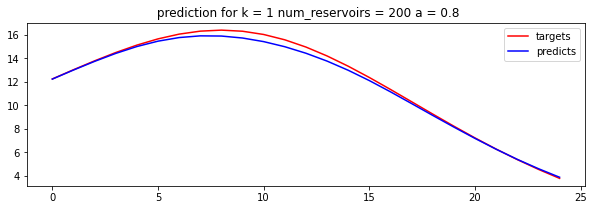

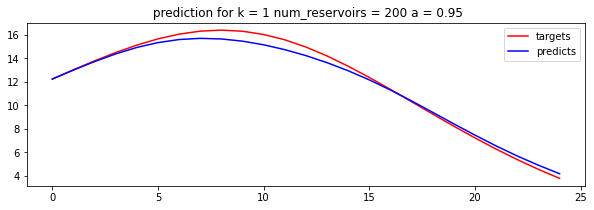

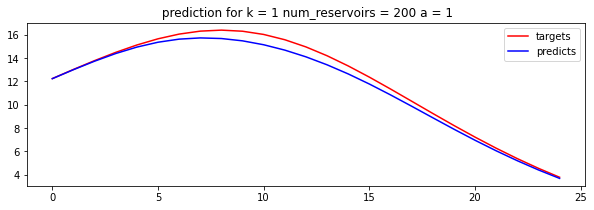

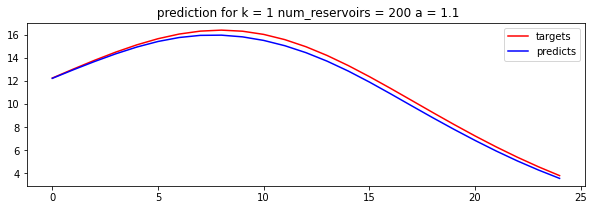

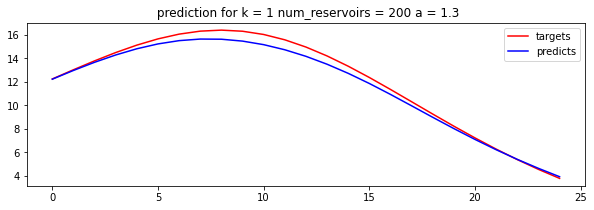

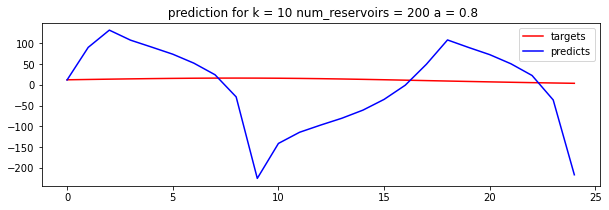

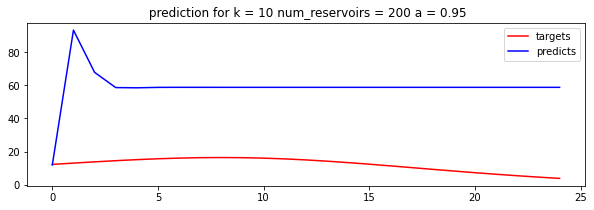

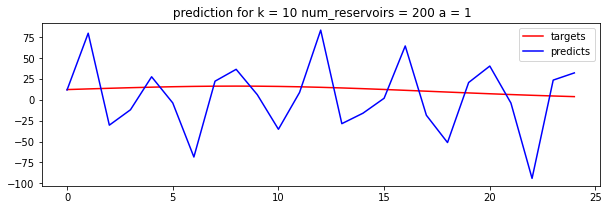

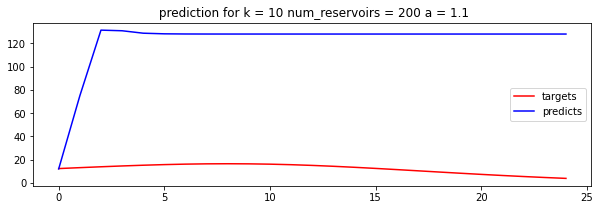

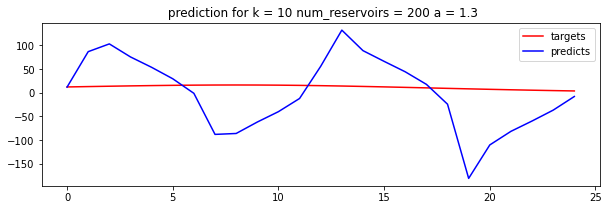

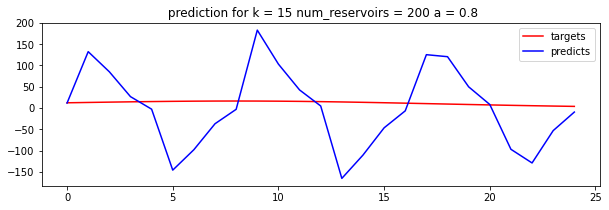

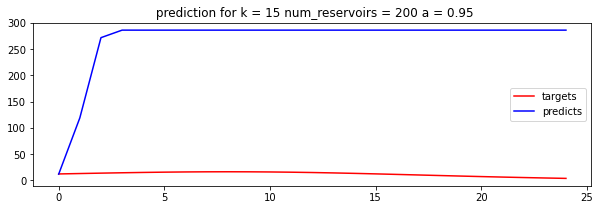

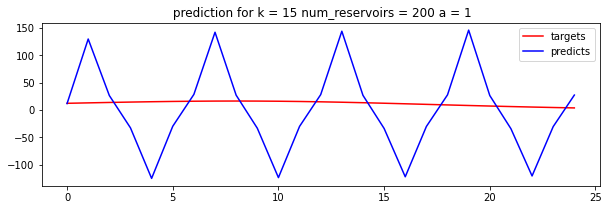

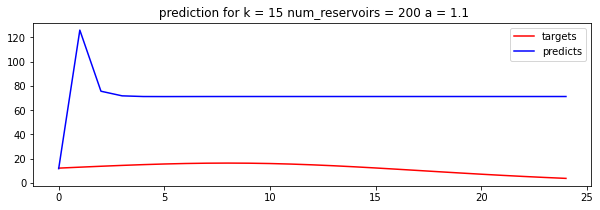

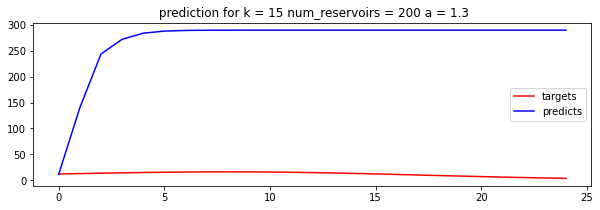

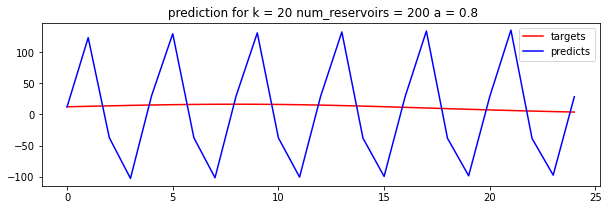

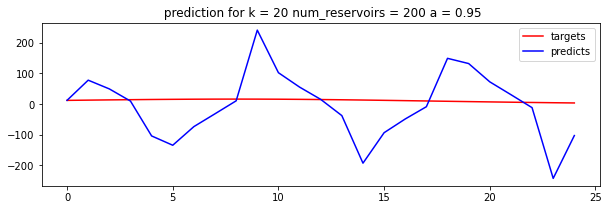

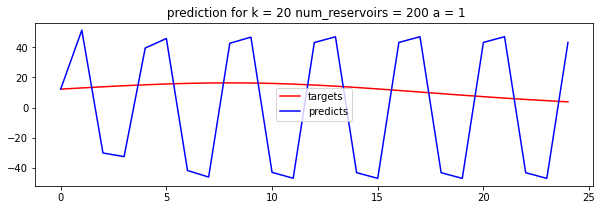

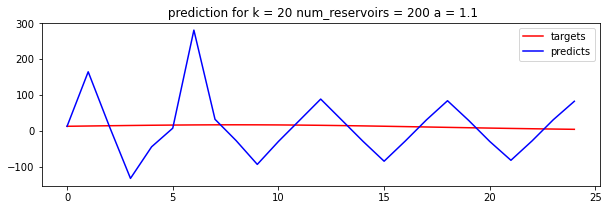

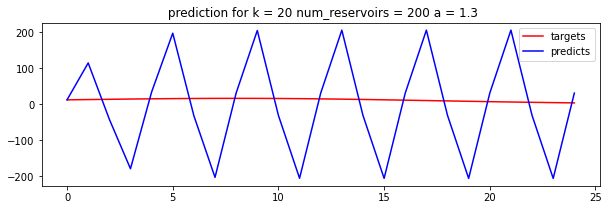

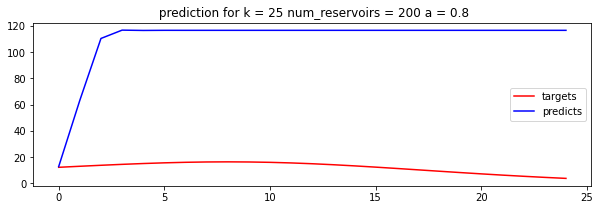

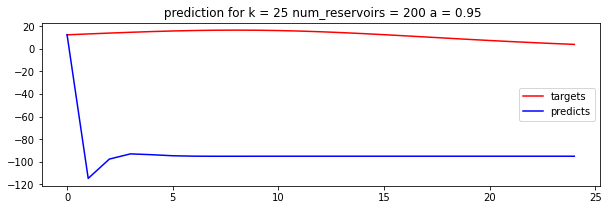

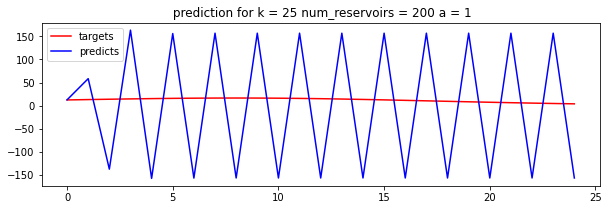

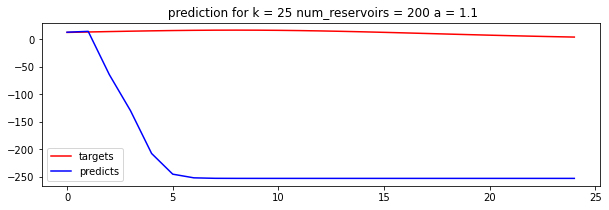

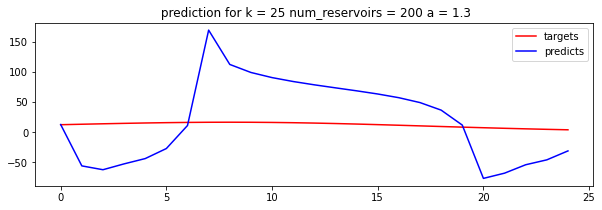

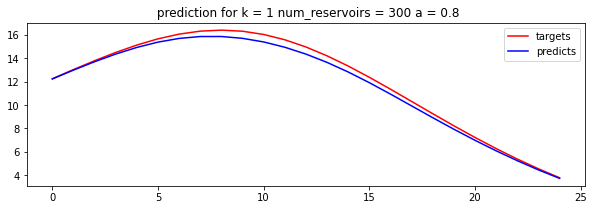

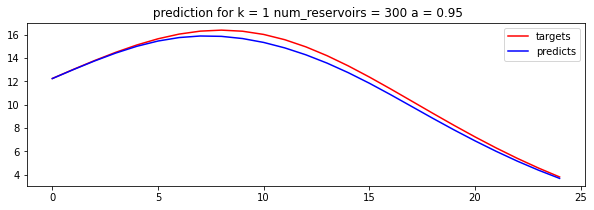

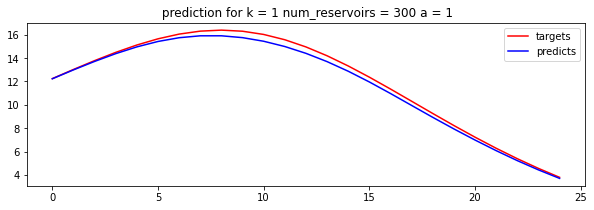

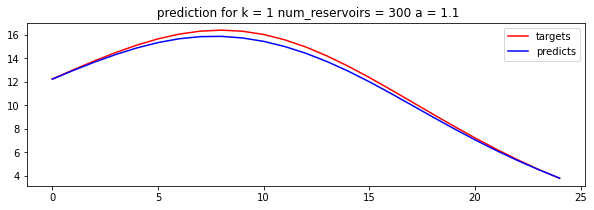

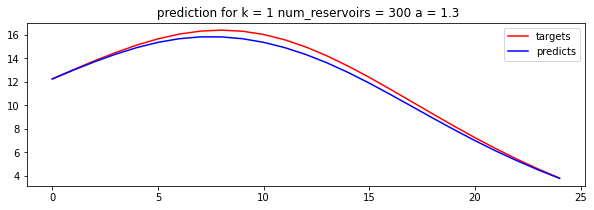

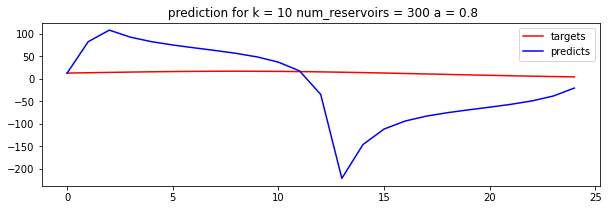

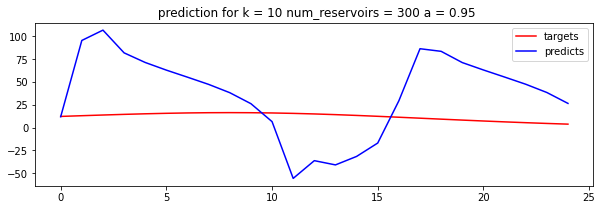

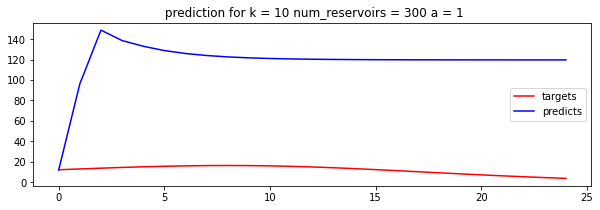

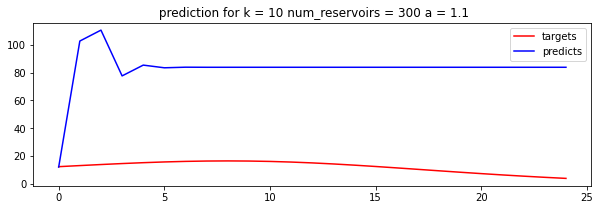

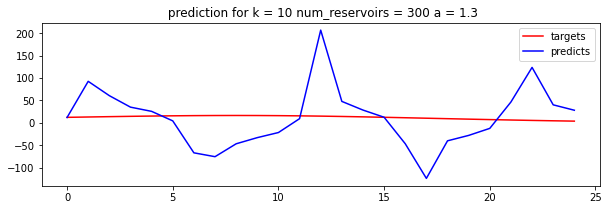

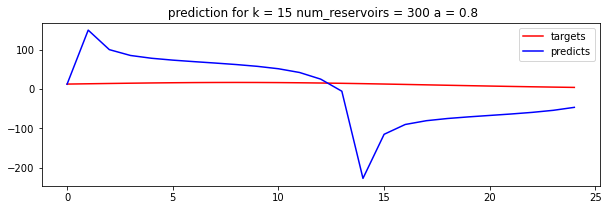

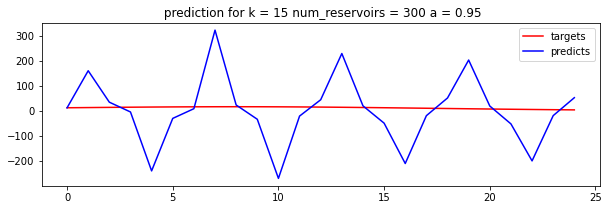

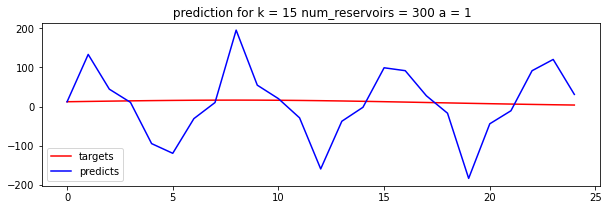

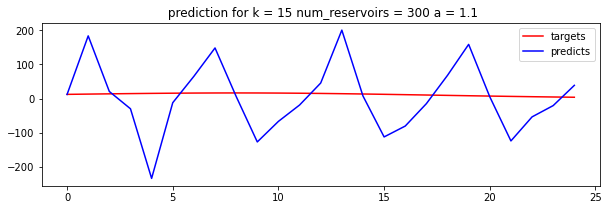

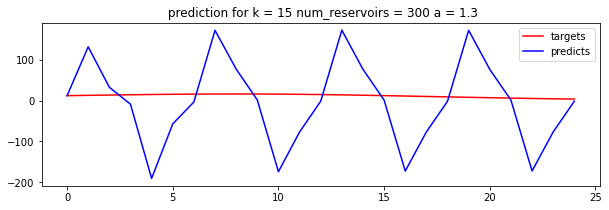

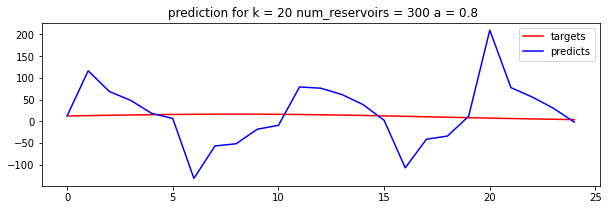

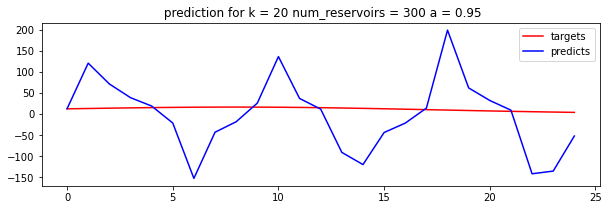

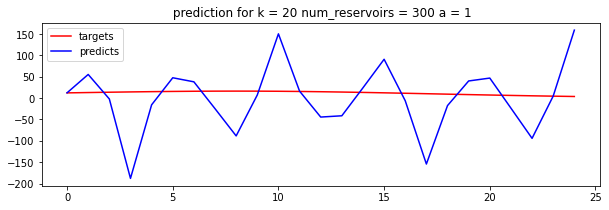

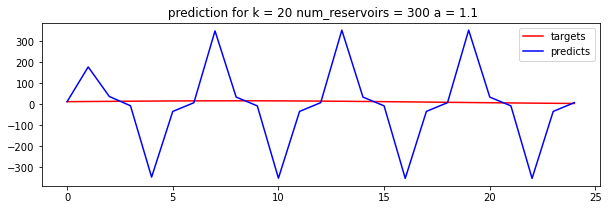

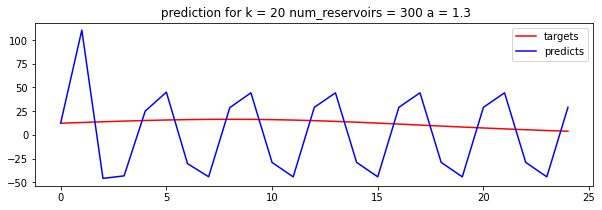

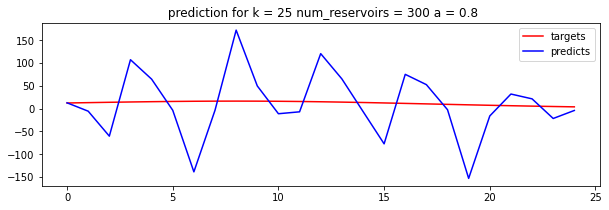

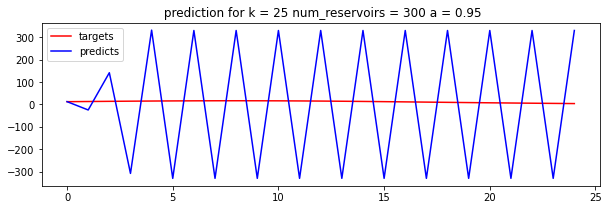

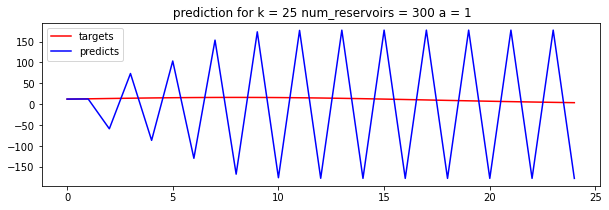

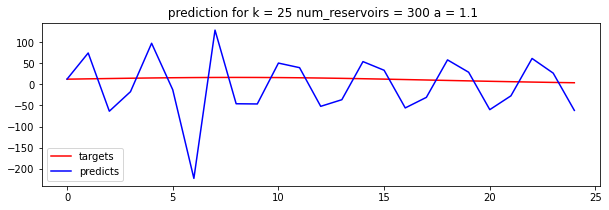

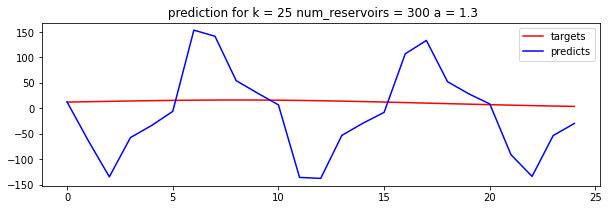

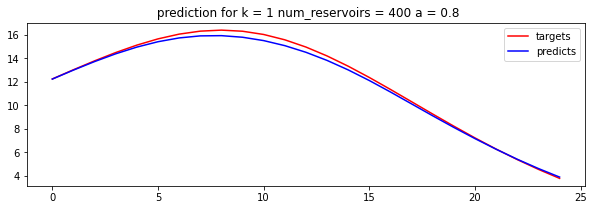

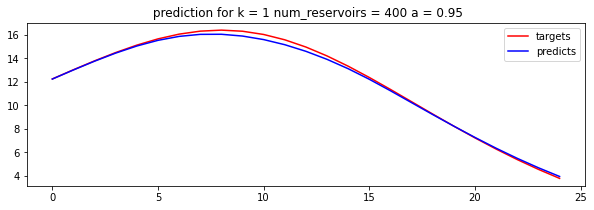

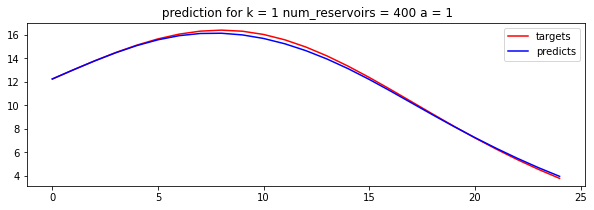

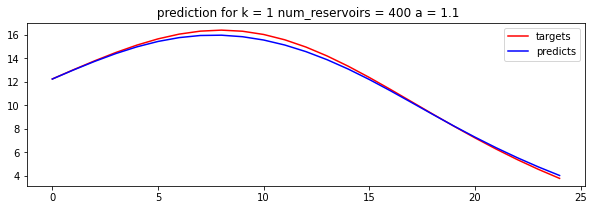

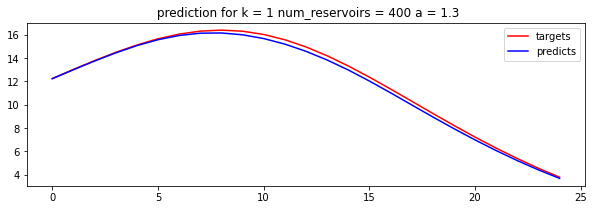

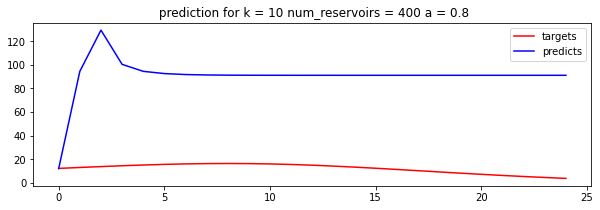

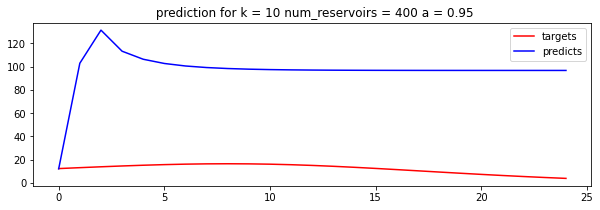

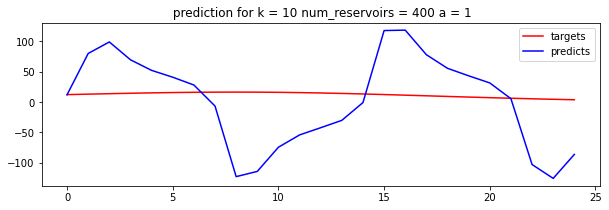

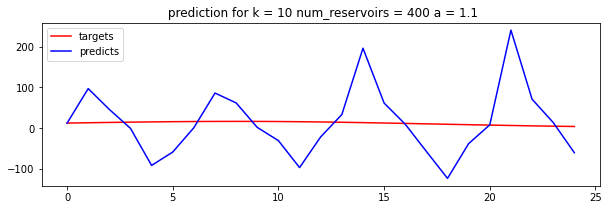

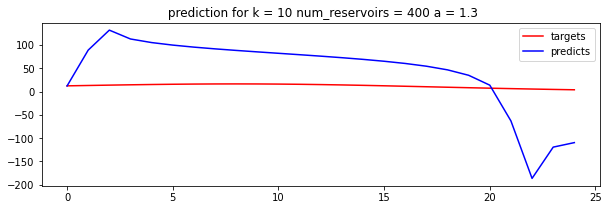

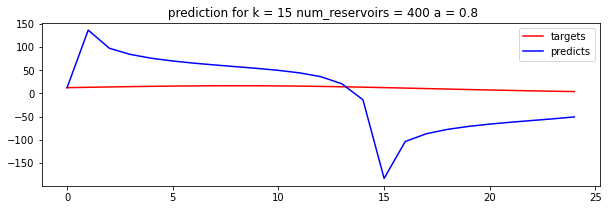

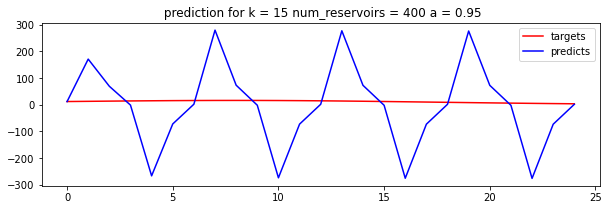

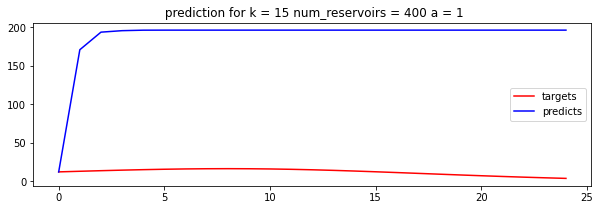

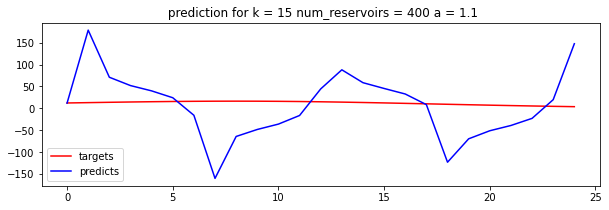

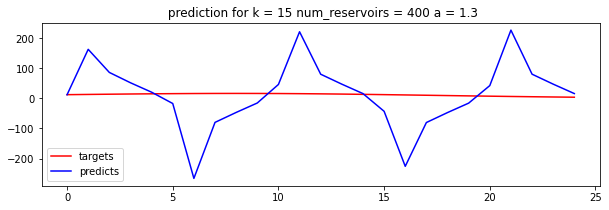

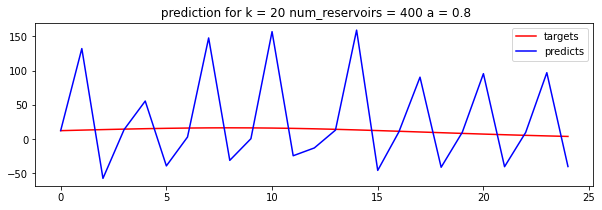

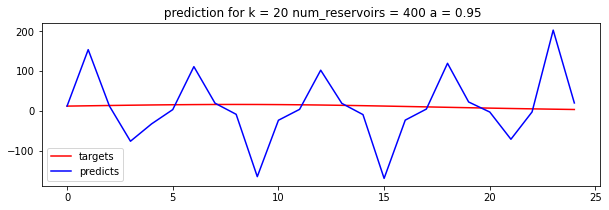

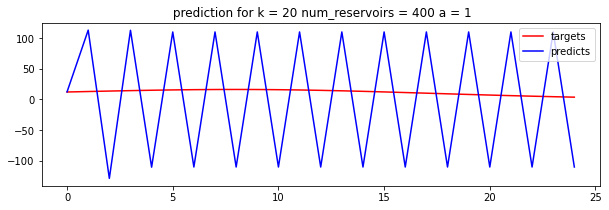

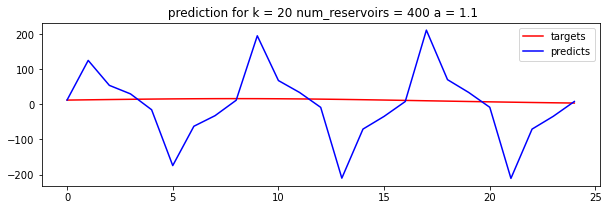

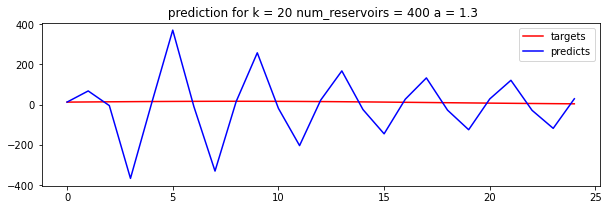

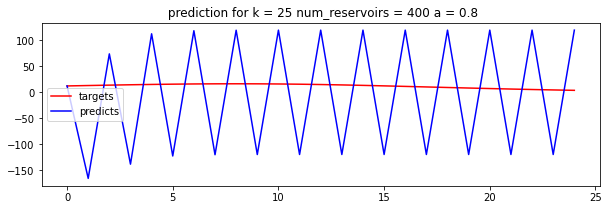

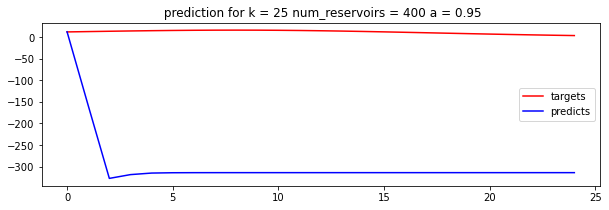

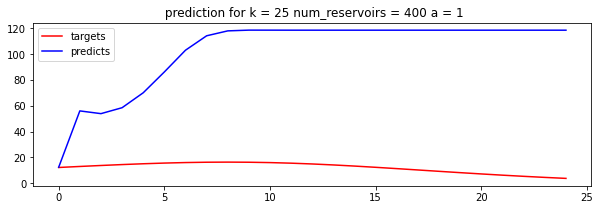

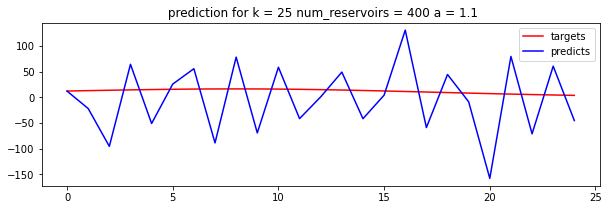

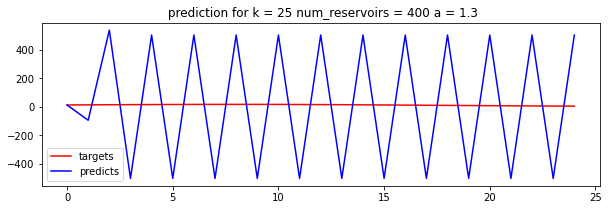

In [298]:
n_reservoirs = [200, 300, 400]
a_tests = [0.8,0.95, 1, 1.1, 1.3]
k_tests = [1, 10, 15, 20, 25]


for num_reservoir in n_reservoirs:
    for k in k_tests:
        for a in a_tests:
            io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split(lorenz_data, k=k)
            lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=num_reservoir)
            lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                                          lorenz_current_state,
                                                                          lorenz_W_in,
                                                                          lorenz_W_r,
                                                                          lorenz_W_out,
                                                                          k=k)
            print('for num reservoirs = ' + str(num_reservoir) + ' and k = ' + str(k) + ' --> loss: '+ str(lorenz_test_loss))
            plot_result_function(lorenz_targets, lorenz_predicts, k, a, num_reservoir)

In [299]:
io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split(lorenz_data, k=25)

In [300]:
lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=400)

In [301]:
lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                                      lorenz_current_state,
                                                                      lorenz_W_in,
                                                                      lorenz_W_r,
                                                                      lorenz_W_out,
                                                                      k=25)

In [302]:
print(lorenz_test_loss)

28941.26920988594


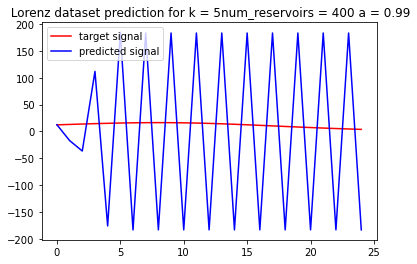

In [303]:
k = 5
a = 0.99
reservoir = 400
plt.figure(11).clear()
plt.plot( lorenz_targets.T, 'r' )
plt.plot( lorenz_predicts.T, 'b' )
plt.title(' Lorenz dataset prediction for k = ' + str(k) + "num_reservoirs = " +str(reservoir) + " a = " + str(a))
plt.legend(['target signal', 'predicted signal'])

### Experiments on 2sin dataset

In [304]:
sin_data = read_file('2sin.txt')

for num reservoirs = 200 and k = 5 --> loss: 184.16982004395538
for num reservoirs = 200 and k = 10 --> loss: 67.23219482513188
for num reservoirs = 200 and k = 15 --> loss: 342.6613005404109
for num reservoirs = 200 and k = 20 --> loss: 533.7358029526825
for num reservoirs = 200 and k = 25 --> loss: 229.91444717593558
for num reservoirs = 300 and k = 5 --> loss: 78.18493773266331
for num reservoirs = 300 and k = 10 --> loss: 72.24956254966793
for num reservoirs = 300 and k = 15 --> loss: 48.125832067826856
for num reservoirs = 300 and k = 20 --> loss: 325.47923555648043
for num reservoirs = 300 and k = 25 --> loss: 332.5210343106537
for num reservoirs = 400 and k = 5 --> loss: 61.42479553071362
for num reservoirs = 400 and k = 10 --> loss: 729.7700116412697
for num reservoirs = 400 and k = 15 --> loss: 35.97945678653405
for num reservoirs = 400 and k = 20 --> loss: 87.57769088673713
for num reservoirs = 400 and k = 25 --> loss: 374.0451047136222


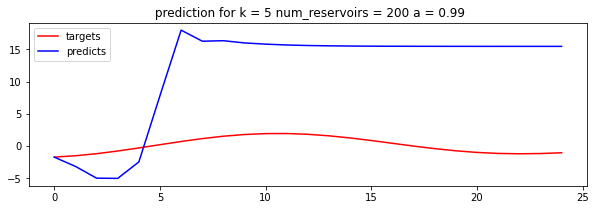

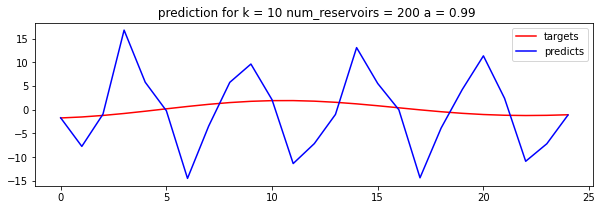

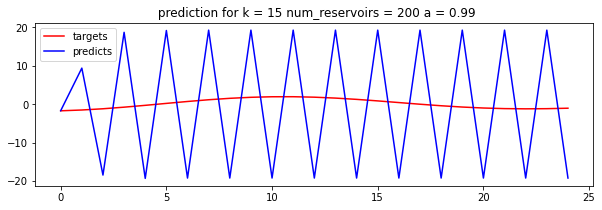

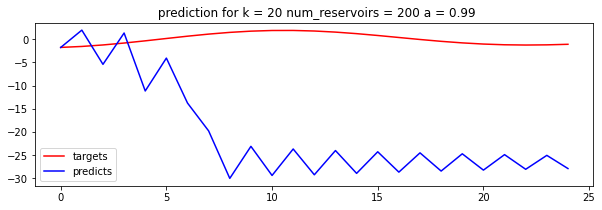

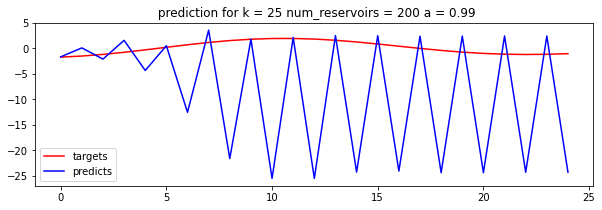

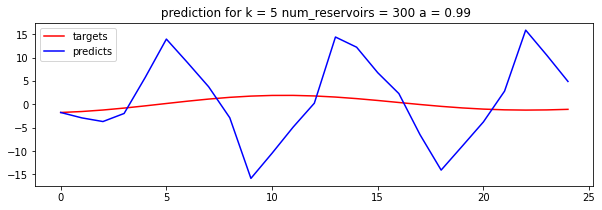

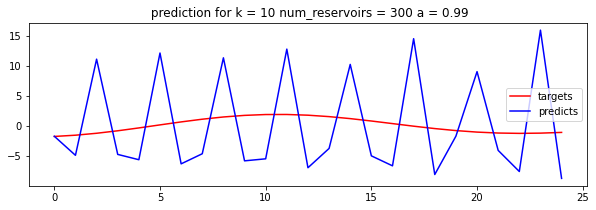

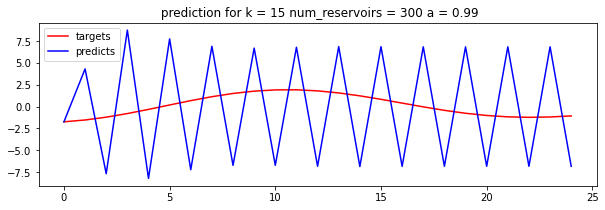

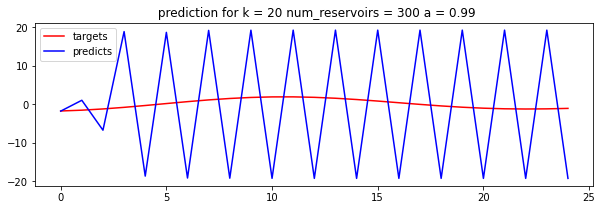

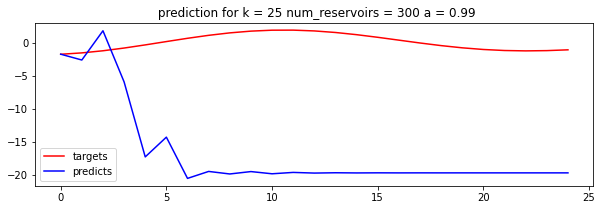

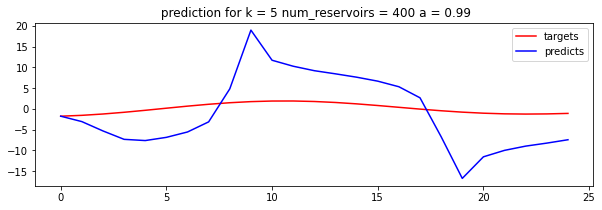

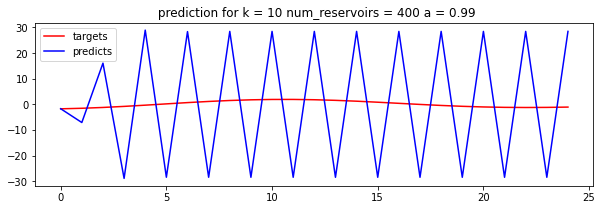

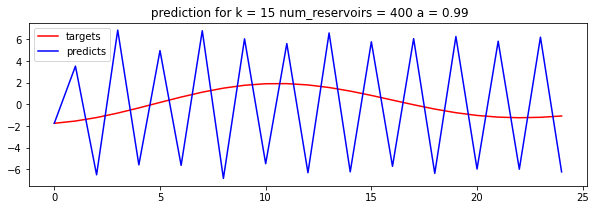

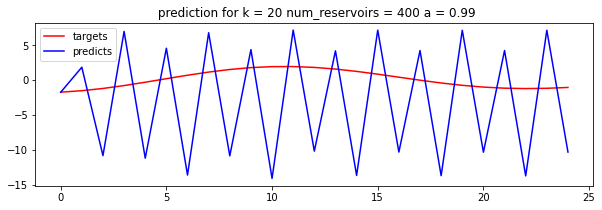

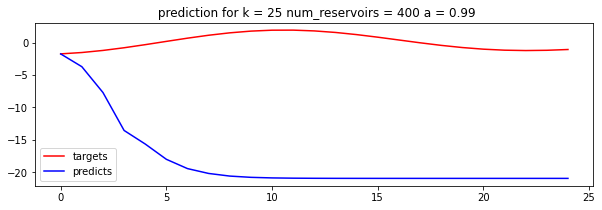

In [305]:
n_reservoirs = [200, 300, 400]
a_tests = [0.8,0.95, 1, 1.1, 1.3]
k_tests = [5, 10, 15, 20, 25]


for num_reservoir in n_reservoirs:
    for k in k_tests:
        io_pair, sin_train_pair, sin_test_pair = train_test_split(sin_data,k=k)
        sin_current_state, sin_W_in, sin_W_r, sin_W_out = ESN_train(sin_train_pair, n_reservoirs=num_reservoir)
        sin_test_loss, sin_targets, sin_predicts = ESN_k_step_predict(sin_test_pair,
                                                          sin_current_state,
                                                          sin_W_in,
                                                          sin_W_r,
                                                          sin_W_out,
                                                          k=k)
        print('for num reservoirs = ' + str(num_reservoir) + ' and k = ' + str(k) + ' --> loss: '+ str(sin_test_loss))
        plot_result_function(sin_targets, sin_predicts, k, a, num_reservoir)

NOTE:
- number of reservoir = 300 and a = 1.1 gives the best results for now
- a <= 1 gives inappropriate result for this case for some reasons(?)
- a=1.1 tends to predict well on all num experimented reservoirs